In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Training using the Dataset as it is.**

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=(5, 13), sigma=(0.1, 0.2)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
dataset = '/content/drive/MyDrive/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

4


In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [ ]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

521
323


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 20
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 0.3997, Accuracy: 83.4933%, 
		Validation : Loss : 0.6156, Accuracy: 83.5913%, Time: 16.9547s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.4077, Accuracy: 85.4127%, 
		Validation : Loss : 0.5371, Accuracy: 81.7337%, Time: 17.1861s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.3349, Accuracy: 89.0595%, 
		Validation : Loss : 0.4875, Accuracy: 83.9009%, Time: 17.0908s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.3625, Accuracy: 85.7965%, 
		Validation : Loss : 0.5044, Accuracy: 83.9009%, Time: 16.1204s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.3847, Accuracy: 86.7562%, 
		Validation : Loss : 0.4522, Accuracy: 84.8297%, Time: 16.7075s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.3473, Accuracy: 88.2917%, 
		Validation : Loss : 0.5213, Accuracy: 83.2817%, Time: 16.9086s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.3391, Accuracy: 88.6756%, 
		Validation : Loss : 0.3659, Accuracy: 86.6873%, Time: 16.5132s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.3037, Accura

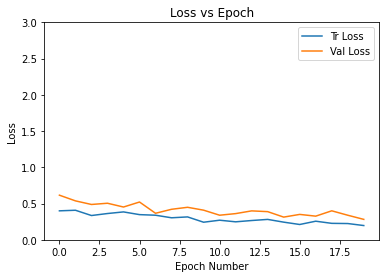

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0,3)
plt.show()

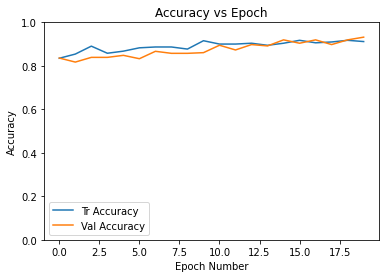

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0,1)
plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

Accuracy of the network: 93 %


In [ ]:
correct_pred = {classname: 0 for classname in os.listdir(train_directory)}
total_pred = {classname: 0 for classname in os.listdir(train_directory)}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = model_ft(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[os.listdir(train_directory)[label]] += 1
            total_pred[os.listdir(train_directory)[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: tomato is 70.8 %
Accuracy for class: watermelon is 98.0 %
Accuracy for class: durian is 98.0 %
Accuracy for class: pumpkin is 96.6 %


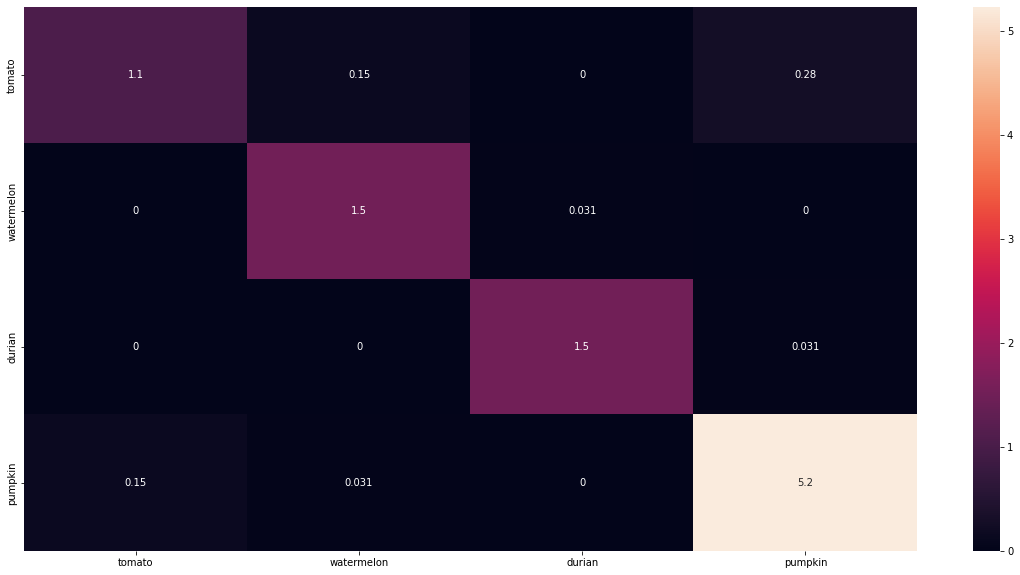

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model_ft.to('cpu')

# iterate over test data
for inputs, labels in testloader:
#         #reshape images so they can be fed to a nn.Linear()
#         inputs = inputs.view(inputs.size(0), -1)
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('tomato', 'watermelon', 'durian', 'pumpkin')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)